In [2]:
import sys
import pathlib
import numpy as np
import pandas as pd
sys.path.insert(0, "../../scripts")
from utils import load_data


from pycytominer.cyto_utils import infer_cp_features


import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.decomposition import PCA
from tensorflow import keras

from vae import VAE

from tensorflow.keras.models import Model, Sequential
import seaborn
import random as python_random
import tensorflow as tf
import umap
import seaborn as sns
from sklearn import preprocessing


In [3]:
data_splits = ["complete"]
data_dict = load_data(data_splits)

In [4]:
cp_features = infer_cp_features(data_dict["complete"])
complete_features_df = data_dict["complete"].reindex(cp_features, axis="columns")

In [5]:
decoder_beta = keras.models.load_model("models/level5Decoder")
decoder_vanilla = keras.models.load_model("models/level5Decoder_vanilla")
decoder_mmd = keras.models.load_model("models/level5Decoder_mmd")

In [6]:
min_max_scaler = preprocessing.MinMaxScaler()

In [7]:
pca = PCA(n_components=10).fit(complete_features_df)
pca_latent_std = pd.DataFrame(pca.transform(complete_features_df)).std().to_list()

In [8]:
organized_dfs = []
organized_dfs_scaled = []

decoders = [decoder_vanilla, decoder_beta, decoder_mmd, 'pca']
for decoder in decoders:
    difference_df = pd.DataFrame()
    for i in range(0,10):
        latent_features_negative = [0,0,0,0,0,0,0,0,0,0]
        latent_features_positive = [0,0,0,0,0,0,0,0,0,0]
        
        if decoder == 'pca':
            latent_features_negative[i] = -3  * pca_latent_std[i]
            latent_features_positive[i] = 3* pca_latent_std[i]
            latent_features_negative = np.array([latent_features_negative])
            latent_features_positive = np.array([latent_features_positive])
            reconstruction_negative = pd.DataFrame(pca.inverse_transform(latent_features_negative), columns = cp_features)
            reconstruction_positive = pd.DataFrame(pca.inverse_transform(latent_features_positive), columns = cp_features)
        else:
            latent_features_negative[i] = -3
            latent_features_positive[i] = 3
            latent_features_negative = np.array([latent_features_negative])
            latent_features_positive = np.array([latent_features_positive])
            reconstruction_negative = pd.DataFrame(decoder.predict(latent_features_negative), columns = cp_features)
            reconstruction_positive = pd.DataFrame(decoder.predict(latent_features_positive), columns = cp_features)
        difference = np.abs(reconstruction_positive - reconstruction_negative).transpose()
        difference.columns = {i}
        difference_df = pd.concat([difference_df, difference], axis = 1)
    
    difference_df['compartment'] = difference_df.index.str.split('_').str[0]
    difference_df['image_channel'] = difference_df.index.str.split('_').str[3]
    difference_df.loc[~difference_df['image_channel'].isin(['AGP','DNA','ER','Mito','RNA']), ['image_channel']] = 'AreaShape'
    organized_df = difference_df.groupby(['compartment','image_channel']).mean()
    organized_dfs.append(organized_df)
    organized_df_scaled = pd.DataFrame(min_max_scaler.fit_transform(organized_df), index = organized_df.index)
    organized_dfs_scaled.append(organized_df_scaled)

    #     difference_sorted = difference.sort_values(i, ascending=False).head(10)
    #     print('\nLATENT FEATURE', i)
    #     print(difference_sorted)

In [40]:
sns.set(font_scale=.5)

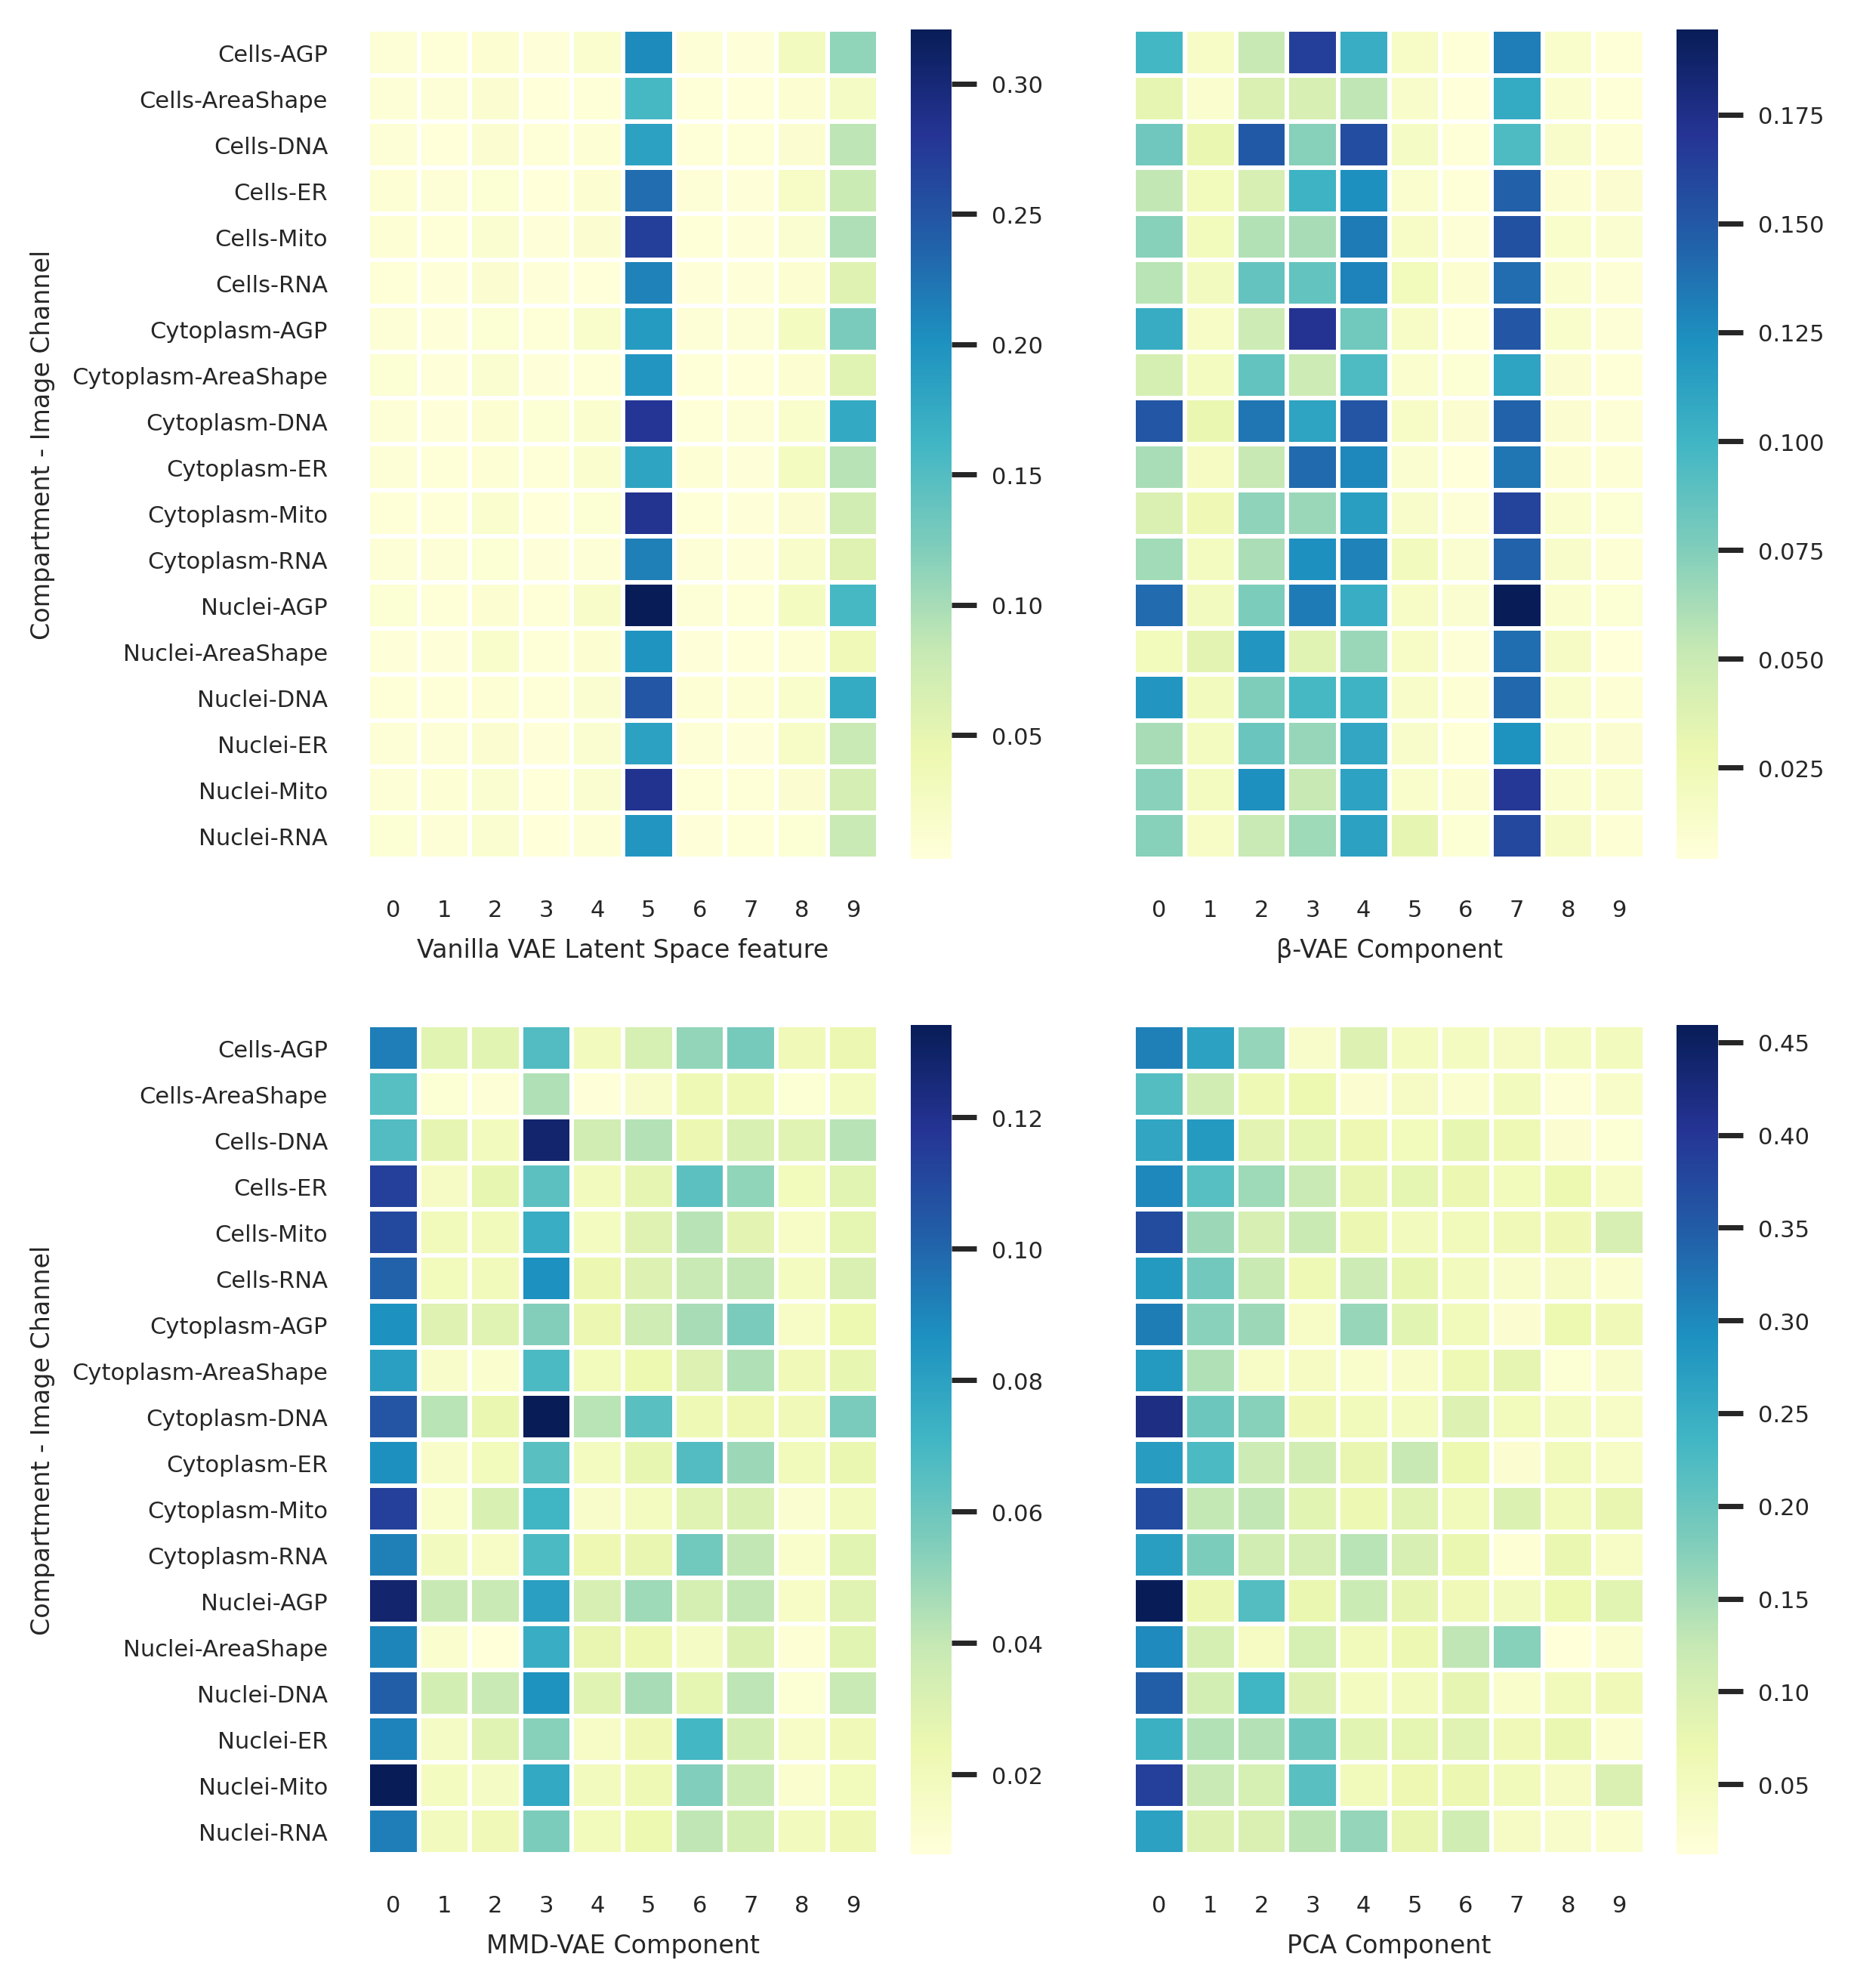

In [41]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(6, 8), dpi=400, sharey = True)

sns.heatmap(organized_dfs[0], ax=ax1, cmap="YlGnBu", linewidths=1)
ax1.set_xlabel("Vanilla VAE Latent Space feature") 
ax1.set_ylabel("Compartment - Image Channel") 

sns.heatmap(organized_dfs[1], ax=ax2, cmap="YlGnBu", linewidths=1)
ax2.set_xlabel("β-VAE Component") 
ax2.set_ylabel("")

sns.heatmap(organized_dfs[2], ax=ax3, cmap="YlGnBu", linewidths=1)
ax3.set_xlabel("MMD-VAE Component") 
ax3.set_ylabel("Compartment - Image Channel")

sns.heatmap(organized_dfs[3], ax=ax4, cmap="YlGnBu", linewidths=1)
ax4.set_xlabel("PCA Component") 
ax4.set_ylabel("")

plt.show()


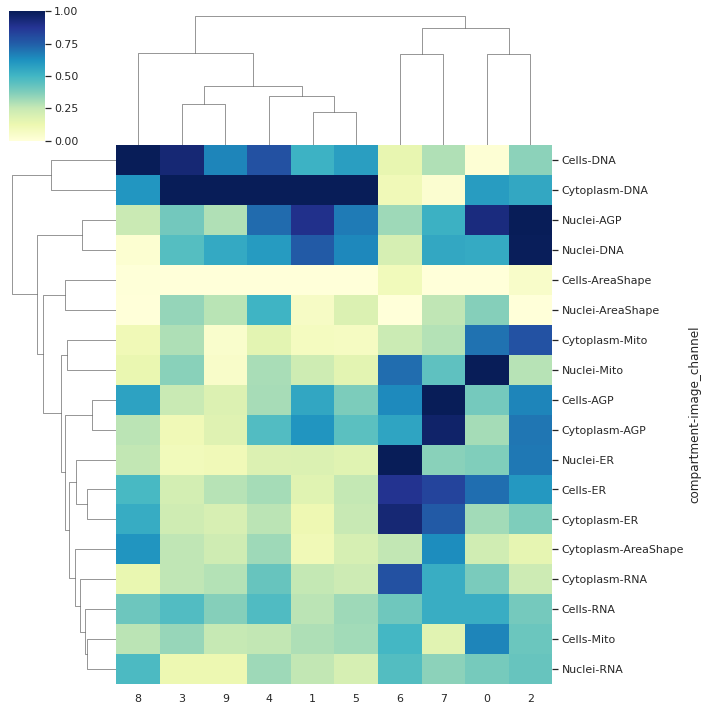

In [37]:
# fig, (ax1, ax2) = plt.subplots(1,2,figsize=(6, 8), dpi=400)
sns.set()
sns.clustermap(organized_dfs_scaled[2], cmap="YlGnBu")
plt.savefig('dendrogram_mmd.jpg',
            dpi=400)